In [ ]:
from place import img_transform, load_finetuned_model, loadModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import numpy as np
from load_datasets import Places
device = 'cuda'



def compute_metrics_at_thresholds(all_probs, all_labels, thresholds):
    """
    Compute precision, recall, F1 for all classes at all thresholds
    
    Args:
        all_probs: (N, 365) numpy array of probabilities
        all_labels: (N,) numpy array of ground truth labels
        thresholds: list of threshold values
    
    Returns:
        dict: metrics[class_idx][threshold_idx] = {'precision', 'recall', 'f1'}
    """
    num_classes = all_probs.shape[1]
    num_samples = len(all_labels)
    
    results = {}
    
    for class_idx in tqdm(range(num_classes), desc="Computing metrics"):
        class_results = []
        class_probs = all_probs[:, class_idx]
        y_true = (all_labels == class_idx).astype(int)
        
        for threshold in thresholds:
            y_pred = (class_probs >= threshold).astype(int)
            
            # Confusion matrix
            tp = np.sum((y_pred == 1) & (y_true == 1))
            fp = np.sum((y_pred == 1) & (y_true == 0))
            fn = np.sum((y_pred == 0) & (y_true == 1))
            tn = np.sum((y_pred == 0) & (y_true == 0))
            
            # Metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
            
            class_results.append({
                'class_idx': class_idx,
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        results[class_idx] = class_results
    
    return results


def main():
    # Configuration
    ALPHA = 1
    BATCH_SIZE = 256  # Larger batches
    NUM_WORKERS = 4
    
    print(f"Using device: {device}")
    
    # Load dataset
    print("\nLoading dataset...")
    places = Places(img_transform)
    places_loader = DataLoader(
        places, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=0,  # Set to 0 to debug
        pin_memory=(device == 'cuda')
    )
    print(f"✓ Loaded {len(places)} images, {len(places_loader)} batches")
    
    # Load models
    print("\nLoading models...")
    finetuned = load_finetuned_model(
        './finetuned_models/resnet50_20251209_111405/best_loss_model_1.pth'
    ).to(device)
    pretrained = loadModel('resnet50').to(device)
    
    finetuned.eval()
    pretrained.eval()
    print(f"✓ Models loaded with alpha={ALPHA}")
    
    # Collect all predictions
    print("\nCollecting predictions...")
    all_probs = []
    all_labels = []
    
    thresholds = [i / 10 for i in range(11)]
    
    print("Starting first batch (this may take a moment)...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(places_loader, desc="Processing batches")):
            if batch_idx == 0:
                print(f"First batch loaded, shape: {images.shape}")
            
            images = images.to(device, non_blocking=True)
            
            if batch_idx == 0:
                print("Running inference on first batch...")
            
            # Get ensemble predictions
            logits = pretrained(images) * ALPHA + finetuned(images) * (1 - ALPHA)
            probs = torch.nn.functional.softmax(logits, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
            
            if batch_idx == 0:
                print("First batch complete!")
    
    # Concatenate all results
    print("\nConcatenating results...")
    all_probs = np.vstack(all_probs)  # (36500, 365)
    all_labels = np.concatenate(all_labels)  # (36500,)
    print(f"✓ Collected predictions: {all_probs.shape}")
    
    # Compute metrics for all classes and thresholds
    print("\nComputing metrics for all classes...")
    results = compute_metrics_at_thresholds(all_probs, all_labels, thresholds)
    
    # Save results
    print("\nSaving results...")
    output_dir = Path('threshold-evaluations-pretrained')
    output_dir.mkdir(exist_ok=True, parents=True)
    
    for class_idx in tqdm(range(365), desc="Saving CSVs"):
        df = pd.DataFrame(results[class_idx])
        csv_path = output_dir / f"class_{class_idx:03d}_thresholds.csv"
        df.to_csv(csv_path, index=False)
    
    print(f"✓ Saved 365 CSV files to {output_dir}/")
    
    # Create summary
    print("\nCreating summary...")
    summary = []
    for class_idx in range(365):
        class_data = results[class_idx]
        best = max(class_data, key=lambda x: x['f1'])
        
        summary.append({
            'class_idx': class_idx,
            'optimal_threshold': best['threshold'],
            'max_f1': best['f1'],
            'precision_at_max_f1': best['precision'],
            'recall_at_max_f1': best['recall']
        })
    
    summary_df = pd.DataFrame(summary)
    summary_path = output_dir / "summary_optimal_thresholds.csv"
    summary_df.to_csv(summary_path, index=False)
    
    print(f"✓ Saved summary to {summary_path}")
    print(f"\nAverage optimal threshold: {summary_df['optimal_threshold'].mean():.3f}")
    print(f"Average max F1 score: {summary_df['max_f1'].mean():.3f}")
    print("\n✅ Done!")


if __name__ == "__main__":
    main()

Using device: cuda

Loading dataset...
✓ Loaded 36500 images, 143 batches

Loading models...
✓ Loaded resnet50 from epoch 1
  Val Accuracy: 63.32%
  Val Loss: 1.8777
Successfully loaded resnet50 weights
✓ Models loaded with alpha=1

Starting first batch (this may take a moment)...


Processing batches:   0%|          | 0/143 [00:00<?, ?it/s]

First batch loaded, shape: torch.Size([256, 3, 224, 224])
Running inference on first batch...


Processing batches:   1%|          | 1/143 [00:01<04:18,  1.82s/it]

First batch complete!


Processing batches: 100%|██████████| 143/143 [03:40<00:00,  1.54s/it]



Concatenating results...
✓ Collected predictions: (36500, 365)

Computing metrics for all classes...


Computing metrics: 100%|██████████| 365/365 [00:00<00:00, 390.30it/s]



Saving results...


Saving CSVs: 100%|██████████| 365/365 [00:00<00:00, 1260.85it/s]

✓ Saved 365 CSV files to threshold-evaluations-pretrained/

Creating summary...
✓ Saved summary to threshold-evaluations-pretrained\summary_optimal_thresholds.csv

Average optimal threshold: 0.291
Average max F1 score: 0.567

✅ Done!


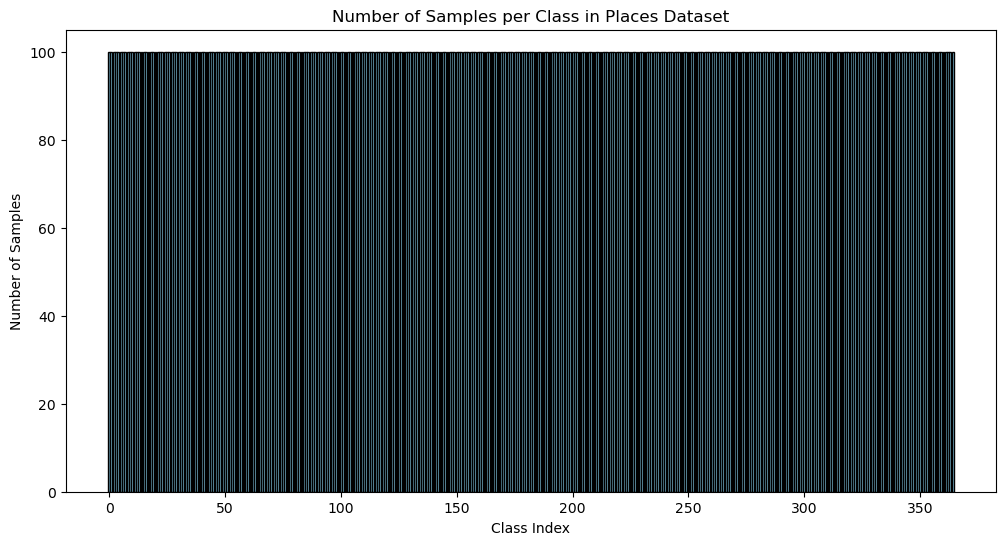

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Suppose your dataset is already instantiated
# Example:
# dataset = Places(img_transform=some_transform)
places = Places(img_transform)
labels = places.labels  # this is a list of ints

# Count number of samples per class
class_counts = Counter(labels)

# If you want to plot sorted by class index
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

# Plot
plt.figure(figsize=(12,6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Places Dataset')
plt.show()
